In [1]:
!pip install velocyto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 11.1 MB/s eta 0:00:00
  Created wheel for velocyto: filename=velocyto-0.17.17-cp38-cp38-linux_x86_64.whl size=389953 sha256=c6f4e9d81cef6ef911abb5715603b6df46e8115562c4d7aeb920cabc65a6cca1
  Stored in directory: /root/.cache/pip/wheels/cd/04/13/c47273eed9825d383b6501e7460ef3400922deb21fea639b6a
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=6fc730caa50a682b24d3777c3dd58b9857f95342650d62580315217dce83bbb6
  Stored in directory: /root/.cache/pip/wheels/51/a8/38/34cd3ac301d305904452deca6780940beb70d059798042fd63
Successfully built velocyto loompy


In [2]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.neighbors import KernelDensity
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline

In [3]:
plt.rcParams['pdf.fonttype'] = 42

In [4]:
def ixs_thatsort_a2b(a: np.ndarray, b: np.ndarray, check_content: bool=True) -> np.ndarray:
    "This is super duper magic sauce to make the order of one list to be like another"
    if check_content:
        assert len(np.intersect1d(a, b)) == len(a), f"The two arrays are not matching"
    return np.argsort(a)[np.argsort(np.argsort(b))]

def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

In [5]:
dp = dict(min_expr_counts=30,
          min_cells_express=20,
          N=1500,
          min_expr_counts_U=20,
          min_cells_express_U=15,
          min_avg_U=0.008,
          min_avg_S=0.08,
          n_comps = 20,
          limit_gamma=False,
          fit_offset=False,
          n_neighbors = 40,
          k = 70)

In [6]:
!mkdir data

In [7]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/Haber_et_al/Haber_et_al.loom",
            "data/Haber_et_al.loom")
urlretrieve("http://pklab.med.harvard.edu/velocyto/Haber_et_al/goatools_cellcycle_genes.txt",
            "data/goatools_cellcycle_genes.txt")

('data/goatools_cellcycle_genes.txt',
 <http.client.HTTPMessage at 0x7fc39f8cedf0>)

In [8]:
cell_cycle_genes = open("data/goatools_cellcycle_genes.txt").read().split()

In [9]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("data/Haber_et_al.loom")  # CHANGE THIS PATH TO YOUR LOCAL PATH

In [10]:
vlm.filter_cells(~np.in1d(vlm.ca["Bamfile"], ["Atlas1", "Atlas2", "Atlas6", "Atlas5"]))

Text(0, 0.5, 'unspliced')

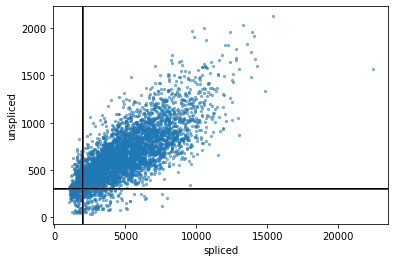

In [11]:
plt.scatter(vlm.initial_cell_size, vlm.initial_Ucell_size, alpha=0.5, s=5)
plt.axvline(2000, c="r", lw=1)
plt.axvline(np.percentile(vlm.initial_cell_size, 8), c="k", lw=1)
plt.axhline(300, c="r", lw=1)
plt.axhline(np.percentile(vlm.initial_Ucell_size, 8), c="k", lw=1)
plt.xlabel("spliced"); plt.ylabel("unspliced")

In [12]:
vlm.filter_cells(bool_array=(vlm.initial_Ucell_size > 300) & (vlm.initial_cell_size > 2000))

In [13]:
# Read column attributes form the loom file and specify colors
colors_dict = {'Endocrine':np.array([137, 34, 81]),
 'Enterocyte.Immature.Distal':np.array([130, 162, 209]),
 'Enterocyte.Immature.Proximal':np.array([224, 139, 183]),
 'Enterocyte.Mature.Distal':np.array([52, 127, 184]),
 'Enterocyte.Mature.Proximal':np.array([150, 81, 156]),
 'Enterocyte.Progenitor':np.array([224, 139, 104]),
 'Enterocyte.Progenitor.Early':np.array([96, 97, 96]),
 'Enterocyte.Progenitor.Late':np.array([107, 194, 165]),
 'Goblet':np.array([225,34,46]),
 'Paneth':np.array([190,190,190]),
 'Stem':np.array([37,139,72]),
 'TA.Early':np.array([249,214,64]),
 'TA.G1':np.array([164,87,44]),
 'TA.G2':np.array([164,209,235]),
 'Tuft':np.array([223,127,49]),
 'TA':np.array([164,87,44]),}
colors_dict = {k:v/256 for k, v in colors_dict.items()}
vlm.ca["Celltype"][np.in1d(vlm.ca["Celltype"], ["TA.G1", "TA.G2"])] = "TA"
vlm.set_clusters(vlm.ca["Celltype"], cluster_colors_dict=colors_dict)

(0.8, 2.0, -1.0, 8.0)

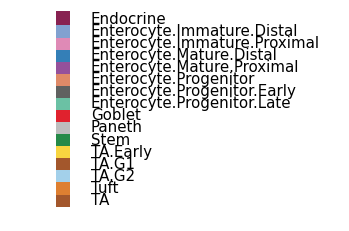

In [16]:
for zz, (k, v) in enumerate(list(colors_dict.items())[::-1]):
    plt.scatter(1, zz/2., c=v, marker="s", lw=0., edgecolor="k", s=220)
    plt.text(1.1, zz/2., k, fontdict={"va":"center", "size":15})
plt.xlim(0.8,2)
plt.ylim(-1,8)
plt.axis("off")

In [17]:
cellamount_dict = {'Enterocyte.Immature.Distal': 244,
 'Enterocyte.Immature.Proximal': 144,
 'Enterocyte.Mature.Distal': 148,
 'Enterocyte.Mature.Proximal': 364,
 'Enterocyte.Progenitor': 117,
 'Enterocyte.Progenitor.Early': 489,
 'Enterocyte.Progenitor.Late': 179,
 'Goblet': 269,
 'Paneth': 78,
 'Stem': 666,
 'TA': 458,
 'TA.Early': 270,
 'Tuft': 76,
 'Endocrine': 137}

In [18]:
dict(zip(*np.unique(vlm.ca["Celltype"], return_counts=1))) ==cellamount_dict

True

In [19]:
from scipy.stats.mstats import gmean, hmean

In [20]:
tosample = int(np.ceil(np.mean(np.unique(vlm.ca["Celltype"], return_counts=1)[1])))
np.random.seed(19900715)
downsaple_ixs = []
for ct in np.unique(vlm.ca["Celltype"]):
    ixs = np.where(vlm.ca["Celltype"] == ct)[0]
    downsaple_ixs.append(np.random.choice(ixs, min(tosample, len(ixs)), replace=False))
downsaple_ixs = np.concatenate(downsaple_ixs)
len(downsaple_ixs)

2683

In [21]:
vlm.filter_cells(bool_array=np.in1d(np.arange(vlm.S.shape[1]), downsaple_ixs))

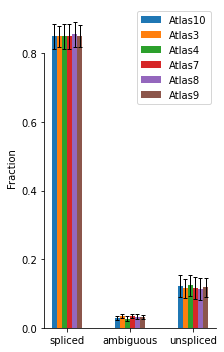

In [22]:
vlm.plot_fractions()

In [23]:
vlm.filter_genes(by_custom_array=~np.in1d(vlm.ra["Gene"], cell_cycle_genes))

In [24]:
vlm.score_detection_levels(min_expr_counts=dp["min_expr_counts"], min_cells_express=dp["min_cells_express"])
vlm.filter_genes(by_detection_levels=True)

In [25]:
# Feature selection - enrichment score
vlm._normalize_S(relative_size=vlm.S.sum(0),
                 target_size=np.median(vlm.S.sum(0)))

M = np.zeros((vlm.S.shape[0], len(np.unique(vlm.cluster_ix))))
F = np.zeros((vlm.S.shape[0], len(np.unique(vlm.cluster_ix))))
for i in np.unique(vlm.cluster_ix):
    D = vlm.S_sz[:, vlm.cluster_ix ==i]
    M[:, i] = D.mean(1)
    F[:, i] = (D>0).mean(1)
Enrich = (M / vlm.S_sz.mean(1)[:,None]) * (F / (vlm.S_sz > 0).mean(1)[:,None])

In [26]:
n = 110
selected = []
for i in np.unique(vlm.cluster_ix):
    selected.append(np.argsort(Enrich[:,i])[::-1][:n])
selected = np.unique(np.concatenate(selected))
selected.shape

(1296,)

In [27]:
vlm.filter_genes(by_custom_array=np.in1d(np.arange(vlm.S.shape[0]), selected))

In [28]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=dp["min_expr_counts_U"], min_cells_express_U=dp["min_cells_express_U"])
vlm.score_cluster_expression(min_avg_U=dp["min_avg_U"], min_avg_S=dp["min_avg_S"])
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

In [29]:
combined_size = (vlm.S.sum(0) / np.percentile(vlm.S.sum(0), 95)) + (vlm.initial_cell_size / np.percentile(vlm.initial_cell_size, 95))
combined_Usize = (vlm.U.sum(0) / np.percentile(vlm.U.sum(0), 95)) + (vlm.initial_Ucell_size / np.percentile(vlm.initial_Ucell_size, 95))
vlm._normalize_S(relative_size=0.25*combined_size*np.median(vlm.S.sum(0)),
                 target_size=np.median(vlm.S.sum(0)))
vlm._normalize_U(relative_size=0.5*combined_Usize*np.median(vlm.U.sum(0)),
                 target_size=np.median(vlm.U.sum(0)))

18

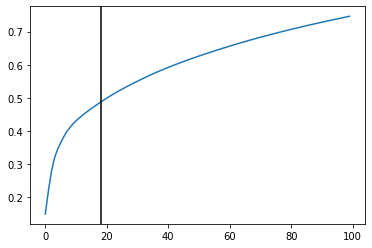

In [30]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.006))[0][0]
plt.axvline(n_comps, c="k"); n_comps

Text(0, 0.5, 'PC5')

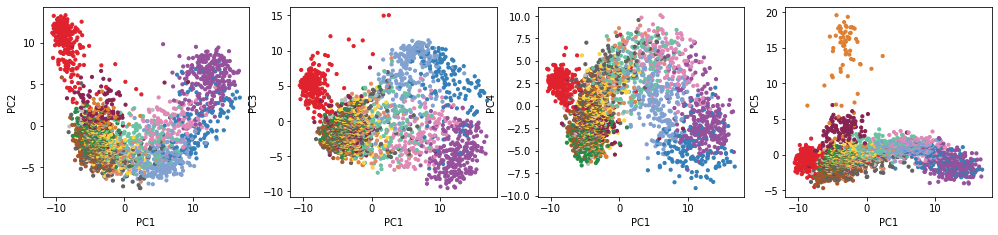

In [31]:
plt.figure(None, (17,3.5))
plt.subplot(141)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,1], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.subplot(142)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,2], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC3")
plt.subplot(143)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,3], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC4")
plt.subplot(144)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,4], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC5")

In [32]:
k = dp["k"] = 70
vlm.knn_imputation(n_pca_dims=9, k=k, balanced=True, b_sight=k*6, b_maxl=int(k*3.5), n_jobs=16)
vlm.fit_gammas(limit_gamma=False, fit_offset=True)

In [33]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_unspliced", delta_t=4)
vlm.extrapolate_cell_at_t(delta_t=1.)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2683 samples in 0.005s...
[t-SNE] Computed neighbors for 2683 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2683
[t-SNE] Computed conditional probabilities for sample 2000 / 2683
[t-SNE] Computed conditional probabilities for sample 2683 / 2683
[t-SNE] Mean sigma: 1.987896
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.366455
[t-SNE] KL divergence after 300 iterations: 1.348913


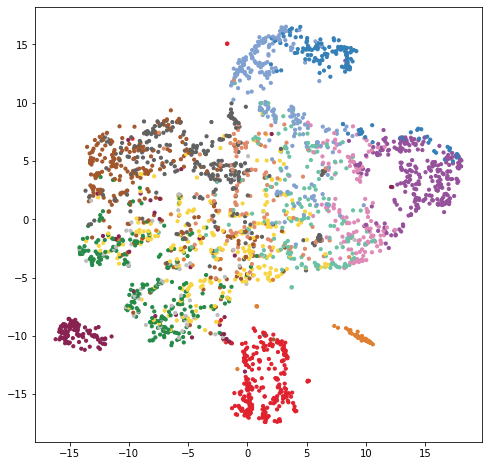

In [34]:
ts =  TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = ts.fit_transform(vlm.pcs[:,:9])
plt.figure(None,(8,8))
vcy.scatter_viz(tsne_results[:,0], tsne_results[:,1], c=vlm.colorandum, s=10)

In [35]:
data = {'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two' : tsne_results[:,1]}

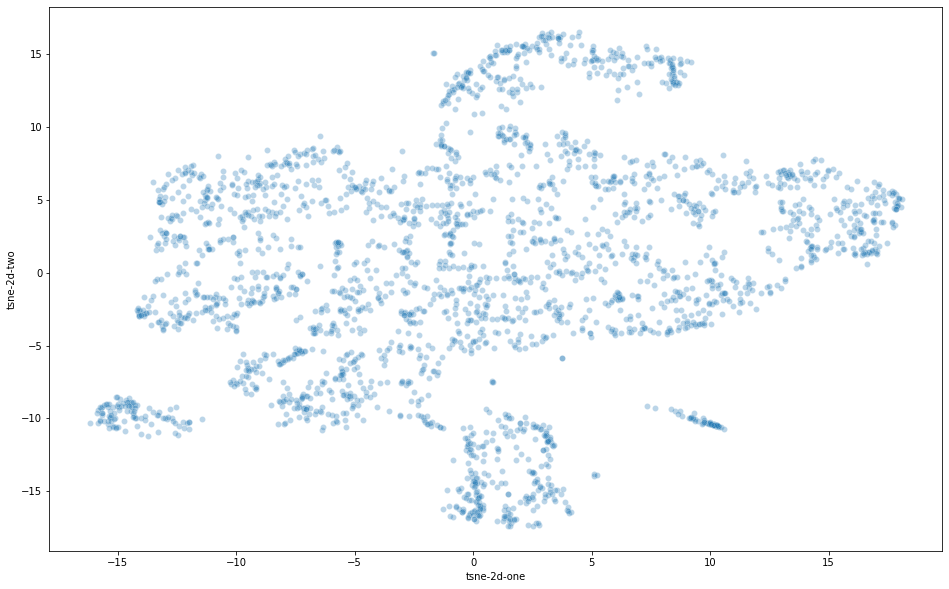

In [36]:
df_subset = pd.DataFrame(data)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [37]:
df_subset.head()

,tsne-2d-one,tsne-2d-two
0,-7.878263,5.081325
1,-13.188772,-0.425856
2,-9.501088,6.266448
3,-0.039306,-14.550997
4,8.667075,5.274601


In [38]:
vlm.ts = tsne_results

In [40]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=30, knn_random=True, sampled_fraction=0.95,
                             calculate_randomized=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
vlm.calculate_embedding_shift(sigma_corr = 0.05)

In [42]:
vlm.calculate_grid_arrows(smooth=0.85, steps=(32, 32), n_neighbors=50)

(0.8, 2.0, -1.0, 8.0)

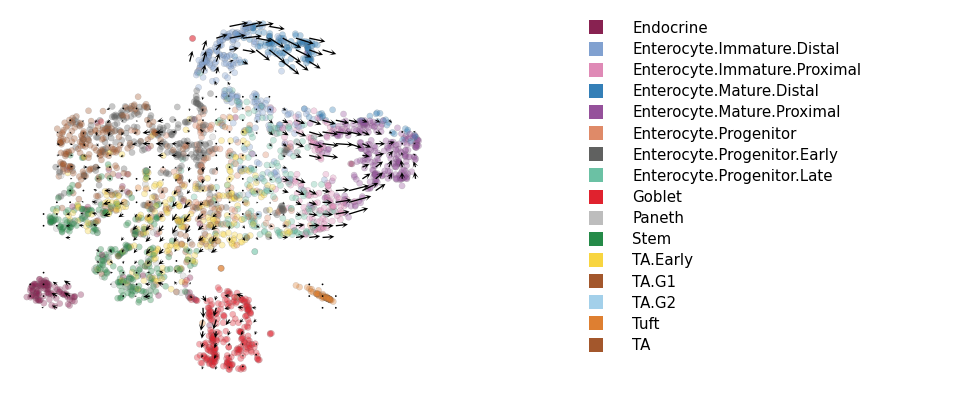

In [43]:
plt.figure(None,(17,7))
plt.subplot(121)
vlm.plot_grid_arrows(quiver_scale=1.4,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True},
                     min_mass=5.5, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=False, scale_type="relative")
plt.subplot(122)
for zz, (k, v) in enumerate(list(colors_dict.items())[::-1]):
    plt.scatter(1, zz/2., c=v, marker="s", lw=0., edgecolor="k", s=220)
    plt.text(1.1, zz/2., k, fontdict={"va":"center", "size":15})
plt.xlim(0.8,2)
plt.ylim(-1,8)
plt.axis("off")

In [44]:
ds = loompy.connect("/content/data/Haber_et_al.loom")

S = np.array(ds["spliced"][:])
cellids = np.array(ds.ca.CellID)
genenames = np.array(ds.ra.Gene)

In [45]:
ds.close()

In [46]:
mask = np.in1d(cellids, vlm.ca["CellID"])
cellids = cellids[mask]
S = S[:, mask]

mask = (S.sum(1) > 20) & ((S>0).sum(1) > 15)
genenames = genenames[mask]
S = S[mask, :]

np.alltrue(cellids == vlm.ca["CellID"])

# Size normalize
S_sz = S / S.sum(0)
# Impute
Sx_sz = vcy.convolve_by_sparse_weights(S_sz, vlm.knn_smoothing_w)

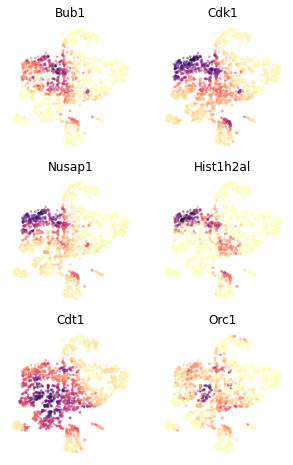

In [47]:
plt.figure(None, (5,8))
gs = plt.GridSpec(3,2)
gene_list = ['Bub1', 'Cdk1', 
             'Nusap1', 'Hist1h2al',
              "Cdt1", "Orc1",]
for i, gene in enumerate(gene_list):
    plt.subplot(gs[i])
    colorandum = Sx_sz[np.where(genenames == gene)[0][0], :]
    vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:, 1], c=colorandum, cmap="magma_r", alpha=0.35, s=3, rasterized=True)
    plt.title(gene)
    plt.axis("off")

In [48]:
k = dp["k"] = 150
vlm.knn_imputation(n_pca_dims=9, k=k, balanced=True, b_sight=k*6, b_maxl=int(k*3.5), n_jobs=16)

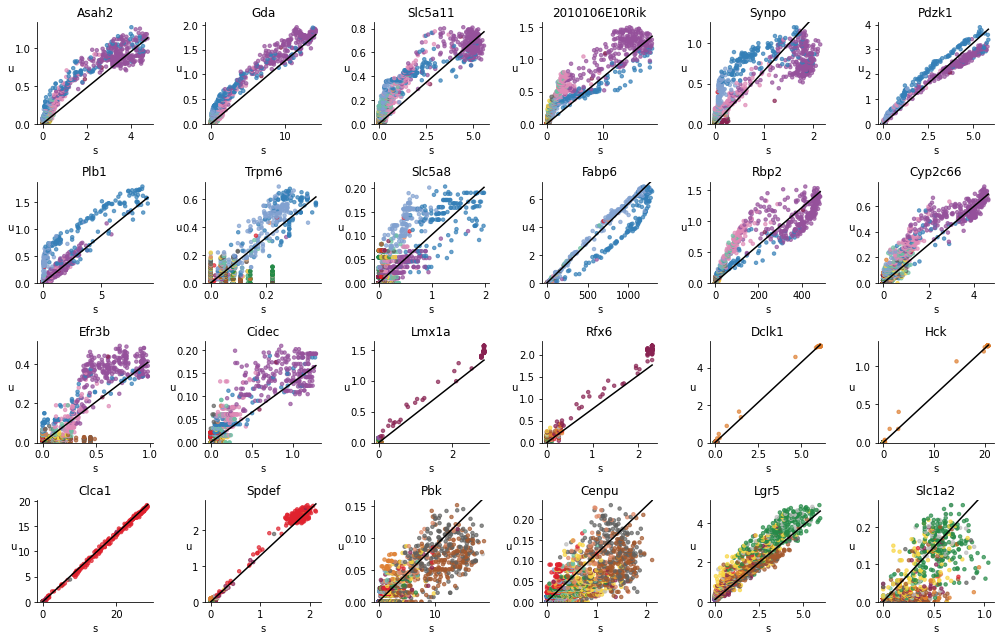

In [49]:
genes = ["Asah2", "Gda", "Slc5a11", '2010106E10Rik',  "Synpo", 'Pdzk1',
         "Plb1", 'Trpm6',  "Slc5a8", 'Fabp6',   'Rbp2', "Cyp2c66", 'Efr3b', 'Cidec', 
         'Lmx1a', "Rfx6",  'Dclk1', 'Hck',  'Clca1',  "Spdef",  
         'Pbk', "Cenpu", "Lgr5", "Slc1a2"]

plt.figure(None, (14,9))
gs = plt.GridSpec(4,6)
for i, gn in enumerate(genes):
    plt.subplot(gs[i])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=12, alpha=0.7, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.05)
    plt.xlabel("s")
    plt.ylabel("u", rotation=0)
    despline()
plt.tight_layout()